In [1]:
import pandas as pd
import numpy as np

# import holidays for colombia
import holidays
from datetime import date



In [2]:
# check if a date is a holiday
def is_holiday(date):
    return date in holidays.CO()

def is_weekend(date):
    return date.weekday() >= 5

today = date.today().strftime("%Y-%m-%d")
print("Today's date:", today , "is holiday?", is_holiday(today))

Today's date: 2024-01-21 is holiday? False


[(0, 39), (10, 29), (24, 20), (26, 3), (53, 0)]
[(80, 66), (61, 95), (90, 7), (40, 17), (98, 39), (15, 80), (73, 30), (33, 18), (83, 63), (50, 11), (91, 13), (37, 20), (40, 13), (99, 7), (71, 69), (14, 50), (8, 86), (81, 74), (75, 2), (15, 46), (30, 20), (63, 74), (4, 79), (26, 3), (65, 81), (0, 39), (68, 29), (19, 29), (24, 20), (41, 47), (53, 0), (77, 46), (12, 94), (38, 36), (60, 29), (65, 37), (10, 29), (85, 1), (5, 59), (26, 72)]


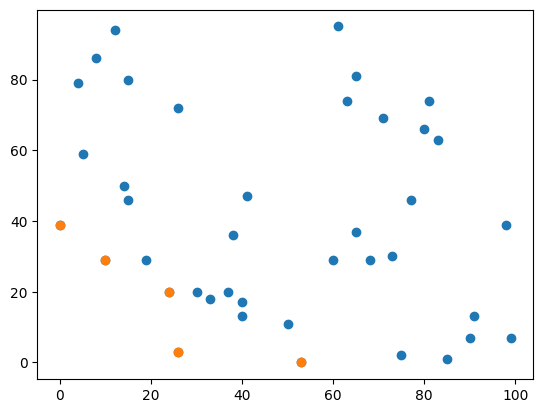

In [3]:
#random set of points
import numpy as np
import matplotlib.pyplot as plt

pairs=[(np.random.randint(0,100),np.random.randint(0,100)) for i in range(40)]


def get_non_dominated_pairs(pairs):
    # sort pairs by first element in ascending order
    
    pairs=sorted(pairs,key=lambda x: x[0])
    
    non_dominated_pairs=[pairs[0]]
    y_min=pairs[0][1]
    
    for i in range(len(pairs)):
        non_dominated=True
        for j in range(i+1,len(pairs)):
            if pairs[j][1]<y_min:
                y_min=pairs[j][1]
                non_dominated_pairs.append(pairs[j])
            else:
                non_dominated=False


            
    return non_dominated_pairs

non_dominated_pairs=get_non_dominated_pairs(pairs)
non_dominated_pairs
print(non_dominated_pairs)
print(pairs)

plt.scatter([i[0] for i in pairs],[i[1] for i in pairs])
plt.scatter([i[0] for i in non_dominated_pairs],[i[1] for i in non_dominated_pairs])

In [4]:
# construct a dataframe with the name of the instance, the objectives and the non-dominated pairs
list_of_instances=[]
for i in range(3,171):
    try:

        prefix='/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/'
        instance_name=f'tabulated_shifts_{i}.csv'

        df=pd.read_csv(prefix+instance_name)

        # skip columns objective_1 and objective_2
        # old_data.loc[:, ~old_data.columns.str.contains('^Unnamed')]
        # melt all columns
        #get columns names
        cols=list(df.columns)

        #remove first column
        cols.pop(0)
        #melt
        df_melt=pd.melt(df,id_vars=['objective_1','objective_2'],value_vars=cols)
        df_melt.drop(columns=['variable'],inplace=True)
        df_melt.drop(columns=['value'],inplace=True)
        
        df_melt['instance_name']=instance_name
        df_melt.drop_duplicates(inplace=True)
        # re-escale objective_1 in the range [0,1] with min-max
        #df_melt['objective_1_scaled'] = (df_melt['objective_1'] - df_melt['objective_1'].min()) / (df_melt['objective_1'].max() - df_melt['objective_1'].min())
        current_min,current_max=df_melt['objective_1'].min(),df_melt['objective_1'].max()
        df_melt['objective_1_scaled'] = df_melt.apply(lambda x: (x['objective_1'] - current_min) / (current_max - current_min) if current_max!=current_min else 1,axis=1)
        # re-escale objective_2 in the range [0,1] with min-max
        #df_melt['objective_2_scaled'] = (df_melt['objective_2'] - df_melt['objective_2'].min()) / (df_melt['objective_2'].max() - df_melt['objective_2'].min())
        current_min,current_max=df_melt['objective_2'].min(),df_melt['objective_2'].max()
        df_melt['objective_2_scaled'] = df_melt.apply(lambda x: (x['objective_2'] - current_min) / (current_max - current_min) if current_max!=current_min else 1,axis=1)
        
        ideal_point=df_melt[['objective_1_scaled','objective_2_scaled']].min().values


        df_melt['distance_to_ideal_point']=df_melt.apply(lambda x: np.sqrt((x['objective_1_scaled']-ideal_point[0])**2+(x['objective_2_scaled']-ideal_point[1])**2),axis=1)

        df_melt['objective_tuples']=df_melt.apply(lambda x: (x['objective_1'],x['objective_2']),axis=1)
        dict_non_dominated=df_melt.groupby(df_melt['instance_name']).agg({'objective_tuples':get_non_dominated_pairs}).reset_index().set_index('instance_name').to_dict()['objective_tuples']

        df_melt['non_dominated']=df_melt.apply(lambda x: 1 if (x['objective_1'],x['objective_2']) in dict_non_dominated[x['instance_name']] else 0,axis=1)
        df_melt=df_melt[df_melt['non_dominated']==1].copy()
        df_melt['non_dominated_size']=len(dict_non_dominated[instance_name])

        df_ins=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/nurses_{i}.json')
        df_ins['dates_off']=df_ins['dates_off'].apply(lambda x: [x[i] for i in range(len(x))])
        df_ins['len_dates_off']=df_ins['dates_off'].apply(lambda x: len(x))
        df_ins['len_vacations']=df_ins['vacations'].apply(lambda x: len(x))
        
        df_ins['vacations_asked']=df_ins['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
        df_ins['total_vacations']=df_ins['vacations'].apply(lambda x: len(x))

        df_res=df_ins.groupby('nurse_name').agg({'dates_off':'sum'
                                                 ,'len_dates_off':'sum'
                                                 ,'len_vacations':'sum'
                                                 ,'vacations_asked':'sum'
                                                 ,'total_vacations':'sum'}).reset_index()
        
        df_melt["total_dates_off"]=df_res['len_dates_off'].sum()
        df_melt["total_vacations"]=df_res['total_vacations'].sum()
        df_melt["total_vacations_asked"]=df_res['vacations_asked'].sum()
        df_melt["total_nurses"]=len(df_res)

        df_shifts=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/shifts_{i}.json')
        #print(df_shifts.head())
        df_shifts['shift_date']=pd.to_datetime(df_shifts['shift_date'])

        shift_dates=df_shifts['shift_date'].unique()
        total_holidays,total_days_weekend=sum([1 for i in shift_dates if is_holiday(i)]),sum([1 for i in shift_dates if is_weekend(i)])
        df_melt['total_holidays']=total_holidays
        df_melt['total_days_weekend']=total_days_weekend
        list_of_instances.append(df_melt)
    except:
        pass


df_final=pd.concat(list_of_instances)

#df_final.to_excel('metrics_instances.xlsx')



In [5]:
dict_len_non_dominated={i:len(dict_non_dominated[i]) for i in dict_non_dominated.keys()}


In [6]:
df_final.dropna(subset=['objective_1_scaled','objective_2_scaled'],inplace=True)
df_final.sort_values(by=['instance_name','objective_1_scaled','objective_2_scaled'],ascending=[True,True,True],inplace=True)
df_final.head(50)

,objective_1,objective_2,instance_name,objective_1_scaled,objective_2_scaled,distance_to_ideal_point,objective_tuples,non_dominated,non_dominated_size,total_dates_off,total_vacations,total_vacations_asked,total_nurses,total_holidays,total_days_weekend
0,8.0,21.4375,tabulated_shifts_10.csv,1.000000,1.000000,0.000000,"(8.0, 21.4375)",1,1,35,16,1,8,2,10
0,2.0,12.6250,tabulated_shifts_102.csv,0.000000,1.000000,1.000000,"(2.0, 12.625)",1,10,46,0,0,10,2,9
10,4.0,11.5000,tabulated_shifts_102.csv,0.200000,0.763158,0.788930,"(4.0, 11.5)",1,10,46,0,0,10,2,9
20,5.0,10.6250,tabulated_shifts_102.csv,0.300000,0.578947,0.652058,"(5.0, 10.625000000000009)",1,10,46,0,0,10,2,9
30,6.0,10.5000,tabulated_shifts_102.csv,0.400000,0.552632,0.682204,"(6.0, 10.5)",1,10,46,0,0,10,2,9
40,7.0,9.6250,tabulated_shifts_102.csv,0.500000,0.368421,0.621075,"(7.0, 9.625000000000004)",1,10,46,0,0,10,2,9
50,8.0,9.5000,tabulated_shifts_102.csv,0.600000,0.342105,0.690678,"(8.0, 9.5)",1,10,46,0,0,10,2,9
60,9.0,8.6250,tabulated_shifts_102.csv,0.700000,0.157895,0.717587,"(9.0, 8.625000000000004)",1,10,46,0,0,10,2,9
70,10.0,8.5000,tabulated_shifts_102.csv,0.800000,0.131579,0.810748,"(10.0, 8.5)",1,10,46,0,0,10,2,9
80,11.0,8.0625,tabulated_shifts_102.csv,0.900000,0.039474,0.900865,"(11.0, 8.0625)",1,10,46,0,0,10,2,9


In [ ]:
cols_to_analyze=['total_dates_off','total_vacations','total_vacations_asked','total_nurses','total_holidays','total_days_weekend']
df_final['instance_number']=df_final['instance_name'].apply(lambda x: int(x.split('_')[2].split('.')[0]))
df_plots=df_final[['instance_number','total_dates_off','total_vacations','total_vacations_asked','total_nurses','total_holidays','total_days_weekend','non_dominated_size']].drop_duplicates().sort_values(by=['instance_number'],ascending=[True])

#plot each column against the non-dominated size using seaborn graphical objects
import matplotlib.pyplot as plt
import seaborn as sns
for i in cols_to_analyze:
    fig,ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(data=df_plots,x=i,y='non_dominated_size')
    plt.title(f'{i} vs non_dominated_size')
    plt.savefig(f'{i}_vs_non_dominated_size.png')



In [23]:
pivot_table = df_plots.pivot(index='instance_number', columns='total_vacations', values='non_dominated_size')
pivot_table.fillna(0)

# give format to the table

total_vacations,0,16,23,32,38,39,45,54,55
instance_number,,,,,,,,,
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
166,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
168,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
len(df_final.instance_name.unique())

117

In [20]:
list_dfs=[]
for i in range(2,171):
    try:
        df=pd.read_csv(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/tabulated_shifts_{i}.csv')

        # skip columns objective_1 and objective_2
        # old_data.loc[:, ~old_data.columns.str.contains('^Unnamed')]
        # melt all columns
        #get columns names
        cols=list(df.columns)


        #remove first column
        cols.pop(0)
        #melt
        df_melt=pd.melt(df,id_vars=['Nurse','objective_1','objective_2'],value_vars=cols)
        
        # re-escale objective_1 in the range [0,1] with min-max
        current_max,current_min=df_melt['objective_1'].max(),df_melt['objective_1'].min()
        #df_melt['objective_1'] = (df_melt['objective_1'] - df_melt['objective_1'].min()) / (df_melt['objective_1'].max() - df_melt['objective_1'].min())
        df_melt['objective_1'] = df_melt.apply(lambda x: (x['objective_1'] - current_min) / (current_max - current_min) if current_max!=current_min else 1,axis=1)
        # re-escale objective_2 in the range [0,1] with min-max
        current_max,current_min=df_melt['objective_2'].max(),df_melt['objective_2'].min()
        #df_melt['objective_2'] = (df_melt['objective_2'] - df_melt['objective_2'].min()) / (df_melt['objective_2'].max() - df_melt['objective_2'].min())
        df_melt['objective_2'] = df_melt.apply(lambda x: (x['objective_2'] - current_min) / (current_max - current_min) if current_max!=current_min else 1,axis=1)
        
        ideal_point=df_melt[['objective_1','objective_2']].min().values


        df_melt['distance_to_ideal_point']=df_melt.apply(lambda x: np.sqrt((x['objective_1']-ideal_point[0])**2+(x['objective_2']-ideal_point[1])**2),axis=1)

        df_melt["horario"]=df_melt["variable"].str.split("-", n = 3, expand = True)[3]
        df_melt['fecha']=df_melt['variable'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1]+'-'+x.split('-')[2])
        df_melt['fecha']=pd.to_datetime(df_melt['fecha'])
        df_melt["works"]=df_melt["value"].apply(lambda x: 1 if x!='-' else 0)
        df_melt["works_morning_shift"]=df_melt.apply(lambda x: 1 if (x['horario']=='mañana'  and x['value']!='-') else 0, axis=1)
        df_melt["works_afternoon_shift"]=df_melt.apply(lambda x: 1 if (x['horario']=='tarde'  and x['value']!='-') else 0, axis=1)
        df_melt['works']=df_melt['works'].astype(int)
        df_melt["works_M"]=df_melt.apply(lambda x: 1 if (x['value']=='M') else 0, axis=1)
        df_melt["works_COM"]=df_melt.apply(lambda x: 1 if (x['value']=='COM') else 0, axis=1)
        df_melt["works_DISP"]=df_melt.apply(lambda x: 1 if (x['value']=='DISP') else 0, axis=1)

        df_melt["works_T1"]=df_melt.apply(lambda x: 1 if (x['value']=='T1') else 0, axis=1)
        df_melt["works_T2"]=df_melt.apply(lambda x: 1 if (x['value']=='T2') else 0, axis=1)
        df_melt["works_CHX"]=df_melt.apply(lambda x: 1 if (x['value']=='CHX') else 0, axis=1)

        df_melt['is_holiday']=df_melt['fecha'].apply(lambda x: is_holiday(x))
        df_melt['is_weekend']=df_melt['fecha'].apply(lambda x: is_weekend(x))

        df_res=df_melt.groupby(['Nurse','objective_1','objective_2']).agg({'works':'sum'
                                                                           ,'works_morning_shift':'sum'
                                                                           ,'works_afternoon_shift':'sum'
                                                                           ,'works_M':'sum'
                                                                           ,'works_COM':'sum'
                                                                           ,'works_DISP':'sum'
                                                                           ,'works_T1':'sum'
                                                                           ,'works_T2':'sum'
                                                                           ,'works_CHX':'sum'
                                                                           , 'is_holiday':'sum'
                                                                            , 'is_weekend':'sum'
                                                                            ,'distance_to_ideal_point':'min'
                                                                           }).reset_index()
        
        df_ins=pd.read_json(f'instances/nurses_{i}.json')
        df_ins['dates_off']=df_ins['dates_off'].apply(lambda x: [x[i] for i in range(len(x))])
        df_ins['len_dates_off']=df_ins['dates_off'].apply(lambda x: len(x))
        df_ins['len_vacations']=df_ins['vacations'].apply(lambda x: len(x))
        
        df_ins['vacations_asked']=df_ins['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
        df_ins['total_vacations']=df_ins['vacations'].apply(lambda x: len(x))

        df_ins['instance']=i
        list_dfs.append(df_ins.merge(df_res,how='left',left_on='nurse_name',right_on='Nurse'))
    except:
        print(i)
        pass

df_all=pd.concat(list_dfs)


2
4
11
17
18
21
22
23
26
27
29
35
38
44
45
46
49
50
57
60
62
63
65
67
69
71
72
76
81
82
91
93
100
101
104
108
119
122
128
129
133
134
136
137
141
142
144
146
151
153
155
165


In [21]:
df_all.to_pickle('instances/all_instances_results.pkl')
df_all

,nurse_id,nurse_name,shift_preference,morning_availability_labor_day,morning_availability_weekend,afternoon_availability_labor_day,afternoon_availability_weekend,dates_off,accumulated_hours,vacations,...,works_afternoon_shift,works_M,works_COM,works_DISP,works_T1,works_T2,works_CHX,is_holiday,is_weekend,distance_to_ideal_point
0,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,7,8,4,2,5,2,0,4,18,1.000000
1,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,2,9,9,1,1,1,0,4,18,0.665107
2,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,6,8,5,3,3,2,1,4,18,0.766440
3,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,5,5,11,2,3,2,0,4,18,1.000000
4,20,person_2,morning,0,1,1,1,[],-19.0,[],...,7,9,7,0,5,0,2,4,18,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,2,13,7,0,0,1,1,4,18,0.663331
192,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,2,9,10,2,0,1,1,4,18,0.717800
193,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,5,18,21,2,1,1,3,8,36,0.766613
194,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,9,21,14,2,0,6,3,8,36,0.882026


In [22]:
len(df_all['instance'].unique())

117

In [23]:
df_all['objective_tuples']=df_all.apply(lambda x: (x['objective_1'],x['objective_2']),axis=1)
dict_non_dominated=df_all.groupby(df_all['instance']).agg({'objective_tuples':get_non_dominated_pairs}).reset_index().set_index('instance').to_dict()['objective_tuples']
df_all['non_dominated']=df_all.apply(lambda x: 1 if (x['objective_1'],x['objective_2']) in dict_non_dominated[x['instance']] else 0,axis=1)



In [24]:
dict_non_dominated[98]

[(1.0, 1.0)]

In [25]:
df_all['proportion_of_shifts_in_preference']=df_all.apply(lambda x: x['works_morning_shift']/x['works'] if x['shift_preference']=='morning' else x['works_afternoon_shift']/x['works'],axis=1)

pd.set_option('display.max_columns', None)
df_all['vacations_askes']=df_all['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
df_all['total_vacations']=df_all['vacations'].apply(lambda x: len(x))
df_all.head(20)

,nurse_id,nurse_name,shift_preference,morning_availability_labor_day,morning_availability_weekend,afternoon_availability_labor_day,afternoon_availability_weekend,dates_off,accumulated_hours,vacations,len_dates_off,len_vacations,vacations_asked,total_vacations,instance,Nurse,objective_1,objective_2,works,works_morning_shift,works_afternoon_shift,works_M,works_COM,works_DISP,works_T1,works_T2,works_CHX,is_holiday,is_weekend,distance_to_ideal_point,objective_tuples,non_dominated,proportion_of_shifts_in_preference,vacations_askes
0,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],5,0,0,0,3,person_1,0.00,1.000000,21,14,7,8,4,2,5,2,0,4,18,1.000000,"(0.0, 1.0)",1,0.666667,0
1,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],5,0,0,0,3,person_1,0.50,0.438596,21,19,2,9,9,1,1,1,0,4,18,0.665107,"(0.5, 0.43859649122807015)",1,0.904762,0
2,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],5,0,0,0,3,person_1,0.75,0.157895,22,16,6,8,5,3,3,2,1,4,18,0.766440,"(0.75, 0.15789473684210525)",1,0.727273,0
3,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],5,0,0,0,3,person_1,1.00,0.000000,23,18,5,5,11,2,3,2,0,4,18,1.000000,"(1.0, 0.0)",1,0.782609,0
4,20,person_2,morning,0,1,1,1,[],-19.0,[],0,0,0,0,3,person_2,0.00,1.000000,23,16,7,9,7,0,5,0,2,4,18,1.000000,"(0.0, 1.0)",1,0.695652,0
5,20,person_2,morning,0,1,1,1,[],-19.0,[],0,0,0,0,3,person_2,0.50,0.438596,21,19,2,11,5,3,1,0,1,4,18,0.665107,"(0.5, 0.43859649122807015)",1,0.904762,0
6,20,person_2,morning,0,1,1,1,[],-19.0,[],0,0,0,0,3,person_2,0.75,0.157895,22,18,4,10,7,1,0,1,3,4,18,0.766440,"(0.75, 0.15789473684210525)",1,0.818182,0
7,20,person_2,morning,0,1,1,1,[],-19.0,[],0,0,0,0,3,person_2,1.00,0.000000,24,24,0,15,6,3,0,0,0,4,18,1.000000,"(1.0, 0.0)",1,1.000000,0
8,12,person_3,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-23.5,[],5,0,0,0,3,person_3,0.00,1.000000,23,23,0,19,1,3,0,0,0,4,18,1.000000,"(0.0, 1.0)",1,1.000000,0
9,12,person_3,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-23.5,[],5,0,0,0,3,person_3,0.50,0.438596,21,19,2,16,1,2,1,0,1,4,18,0.665107,"(0.5, 0.43859649122807015)",1,0.904762,0


In [26]:
df_all.groupby(['instance','objective_1','objective_2']).agg({'works':['mean','std','max','min'],'proportion_of_shifts_in_preference':['mean','std']}).reset_index()

instance objective_1 objective_2      works                    \
                                           mean       std max min   
0          3      0.0000    1.000000  20.125000  2.531939  23  17   
1          3      0.5000    0.438596  20.875000  1.552648  24  19   
2          3      0.7500    0.157895  22.000000  1.603567  25  20   
3          3      1.0000    0.000000  22.625000  1.922610  26  20   
4          5      0.0000    1.000000  18.500000  1.927248  22  16   
..       ...         ...         ...        ...       ...  ..  ..   
699      170      0.6250    0.222222  22.142857  2.315737  26  19   
700      170      0.6875    0.206349  22.500000  2.244652  26  19   
701      170      0.7500    0.158730  45.357143  4.465373  52  38   
702      170      0.8750    0.111111  46.000000  3.941886  52  40   
703      170      1.0000    0.000000  23.428571  1.785165  26  21   

    proportion_of_shifts_in_preference            
                                  mean       std  
0                             0.830584  0.188212  
1                             0.838581  0.135717  
2                             0.828068  0.180522  
3                             0.864155  0.129484  
4                             0.739296  0.191293  
..                                 ...       ...  
699                           0.756828  0.233351  
700                           0.791663  0.205263  
701                           0.768641  0.215560  
702                           0.788189  0.183823  
703                           0.759505  0.223152  

[704 rows x 9 columns]

In [28]:

instance=4
df_shifts=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/shifts_{instance}.json')
df_shifts['instance']=instance
df_shifts[['instance','weekday','shift','shift_type','holiday','demand']].drop_duplicates().reset_index(drop=True)

,instance,weekday,shift,shift_type,holiday,demand
0,4,6,M,morning,True,1
1,4,6,COM,morning,True,0
2,4,6,DISP,morning,True,1
3,4,6,T1,afternoon,True,1
4,4,6,T2,afternoon,True,0
5,4,6,CHX,afternoon,True,0
6,4,0,M,morning,False,2
7,4,0,COM,morning,False,1
8,4,0,DISP,morning,False,0
9,4,0,T1,afternoon,False,1


In [31]:
df_all["non_dominated_size"]=df_all['instance'].apply(lambda x: len(dict_non_dominated[x]))

/var/folders/th/h1p304h17jq5pt71wrjdmbgr0000gn/T/ipykernel_51559/3338425088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="non_dominated_size", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], palette="Set3",ax=ax)


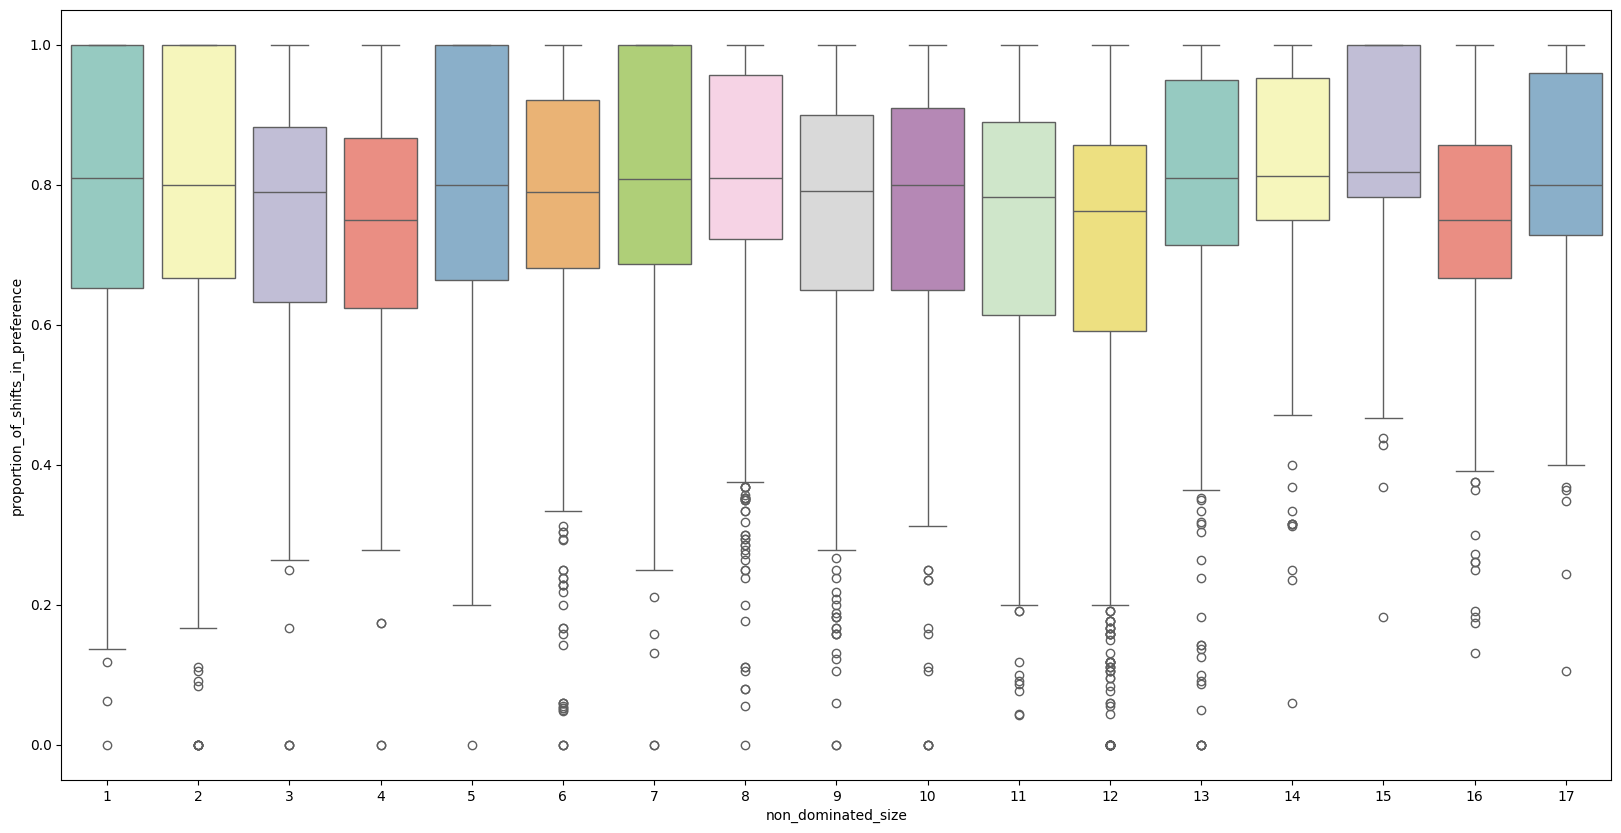

In [32]:
pd.set_option('display.max_rows', None)
df_all[df_all['non_dominated']==1].head(100)

# builds a boxplot for proportion_of_shifts_in_preference using objective_1 
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(x="non_dominated_size", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], palette="Set3",ax=ax)
plt.show()


<Axes: xlabel='objective_2', ylabel='proportion_of_shifts_in_preference'>

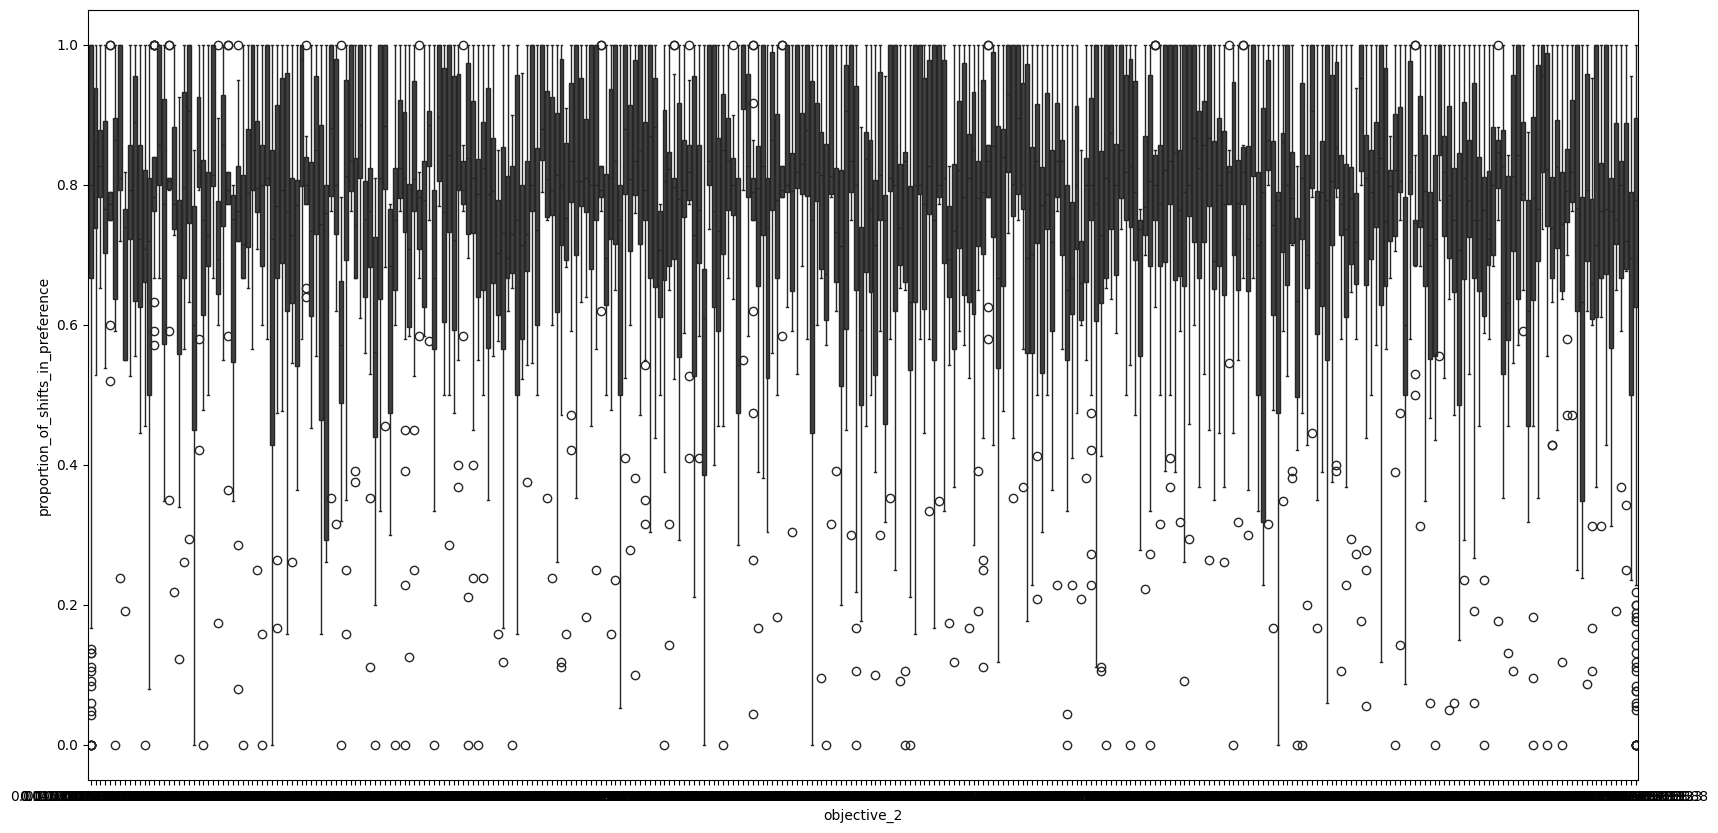

In [20]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(x="objective_2", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], color=".25",ax=ax)
